In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

In [2]:
train = pd.read_csv('../data/train.csv', index_col="ID")
test = pd.read_csv('../data/test.csv', index_col="ID")

In [3]:
train.head()

,measurement_time,target,source_1_temperature,source_2_temperature,source_3_temperature,source_4_temperature,mean_room_temperature,sun_radiation_east,sun_radiation_west,sun_radiation_south,sun_radiation_north,sun_radiation_perpendicular,outside_temperature,wind_speed,wind_direction,clouds
ID,,,,,,,,,,,,,,,,
0,2023-11-01 00:00:00,3.400000,27.600000,18.799999,19.750000,21.100000,20.129892,0.0,0.0,0.0,0.0,0.0,8.97,2.06,140.0,20.0
1,2023-11-01 01:00:00,2.933333,28.400000,18.933333,19.833333,21.033333,20.052919,0.0,0.0,0.0,0.0,0.0,9.19,2.06,110.0,100.0
2,2023-11-01 02:00:00,7.166667,29.400000,19.000000,19.799999,21.000000,19.992375,0.0,0.0,0.0,0.0,0.0,9.42,2.57,140.0,20.0
3,2023-11-01 03:00:00,10.500000,30.100000,19.033333,19.933333,24.600000,19.941565,0.0,0.0,0.0,0.0,0.0,9.19,2.57,150.0,100.0
4,2023-11-01 04:00:00,8.733334,31.866666,19.100000,20.000000,24.700000,19.924502,0.0,0.0,0.0,0.0,0.0,9.99,2.57,160.0,100.0


In [4]:
train.describe()

,target,source_1_temperature,source_2_temperature,source_3_temperature,source_4_temperature,mean_room_temperature,sun_radiation_east,sun_radiation_west,sun_radiation_south,sun_radiation_north,sun_radiation_perpendicular,outside_temperature,wind_speed,wind_direction,clouds
count,7047.000000,7047.000000,7047.000000,7047.000000,7047.000000,7047.000000,7047.000000,7047.000000,7047.000000,7047.000000,7047.000000,7047.000000,7047.000000,7047.000000,7044.000000
mean,13.902992,31.353220,18.285482,18.765825,21.941836,20.591658,131.326270,136.768829,195.958575,47.121580,307.383654,11.023374,4.259801,187.591599,70.425327
std,11.582678,5.961416,1.388247,1.616728,2.111493,1.067446,218.094756,219.425579,272.681407,57.183783,351.661306,6.481420,2.360655,89.276916,33.634026
min,0.466667,17.400000,14.750000,15.200000,16.566667,17.706746,0.000000,0.000000,0.000000,0.000000,0.000000,-5.840000,0.000000,0.000000,0.000000
25%,4.800000,28.612500,17.633334,17.925000,20.829597,19.807871,0.000000,0.000000,0.000000,0.000000,0.000000,6.670000,2.570000,120.000000,40.000000
50%,8.575000,33.300000,18.266666,18.650000,21.533333,20.763321,14.354839,9.225806,10.500000,9.806452,43.806452,10.150000,4.120000,210.000000,75.000000
75%,21.633333,35.641667,18.833333,19.833333,22.600000,21.310412,138.258065,149.467742,416.908602,96.500000,680.032258,15.510000,5.660000,250.000000,100.000000
max,60.533333,47.700001,24.650001,25.533333,31.466667,23.621292,796.000000,807.000000,861.000000,226.000000,889.000000,33.420000,17.490000,360.000000,100.000000


In [5]:
test.head()

,measurement_time,source_1_temperature,source_2_temperature,source_3_temperature,source_4_temperature,mean_room_temperature,sun_radiation_east,sun_radiation_west,sun_radiation_south,sun_radiation_north,sun_radiation_perpendicular,outside_temperature,wind_speed,wind_direction,clouds
ID,,,,,,,,,,,,,,,
7047,2024-08-20 15:00:00,40.349999,16.625000,16.325000,18.650000,21.171070,114.935484,622.645161,565.741935,115.774194,814.483871,23.43,6.17,200.0,20.0
7048,2024-08-20 16:00:00,39.500000,19.333333,17.966667,19.033333,21.464404,97.774194,735.258065,406.677419,99.612903,766.774194,19.10,5.66,210.0,40.0
7049,2024-08-20 17:00:00,37.600001,19.566667,18.775000,19.150001,21.561250,76.612903,749.064516,226.290323,81.967742,681.032258,19.23,2.06,230.0,20.0
7050,2024-08-20 18:00:00,37.299999,19.350000,19.350000,19.050000,21.498269,52.967742,616.451613,67.612903,70.387097,524.322581,18.83,3.60,220.0,20.0
7051,2024-08-20 19:00:00,33.025001,19.066667,19.750000,19.175001,21.417638,25.161290,301.096774,26.838710,88.903226,249.935484,18.12,2.57,220.0,20.0


In [6]:
test.describe()

,source_1_temperature,source_2_temperature,source_3_temperature,source_4_temperature,mean_room_temperature,sun_radiation_east,sun_radiation_west,sun_radiation_south,sun_radiation_north,sun_radiation_perpendicular,outside_temperature,wind_speed,wind_direction,clouds
count,1762.000000,1762.000000,1762.000000,1762.000000,1762.000000,1762.000000,1762.000000,1762.000000,1762.000000,1762.000000,1749.000000,1749.000000,1749.000000,1749.000000
mean,32.619448,18.241127,18.858423,21.241288,21.129415,126.761433,127.182372,227.488036,36.759419,303.374968,14.585026,3.546832,168.091481,65.634077
std,4.443244,1.336386,1.892157,1.321296,0.753414,202.989592,205.237902,303.355534,42.728007,346.052748,4.621586,1.974971,87.101007,36.137892
min,22.625000,15.133333,15.425000,16.650000,19.348259,0.000000,0.000000,0.000000,0.000000,0.000000,1.020000,0.000000,0.000000,0.000000
25%,29.525000,17.256250,16.466667,20.933333,20.623510,0.000000,0.000000,0.000000,0.000000,0.000000,12.070000,2.060000,100.000000,31.000000
50%,32.850000,18.766666,19.600000,21.375000,21.048629,7.297849,5.147312,4.331183,6.033333,31.733333,13.970000,3.090000,180.000000,75.000000
75%,35.525001,19.062500,20.400000,21.875000,21.567796,125.314516,128.991935,456.458333,76.314516,706.838710,17.280000,4.630000,230.000000,100.000000
max,47.175000,23.300001,23.400000,26.400000,24.232470,750.806452,749.064516,850.000000,130.935484,852.290323,28.700000,13.380000,360.000000,100.000000


In [7]:
print(len(test))
print(len(train))

1762
7047


In [8]:
# Check for missing values
print(f"Number of missing values in train: {train.isnull().sum().sum()}")
# print only the columns with missing values and the number of missing values per column in train, if no missing values, no output
print(train.isnull().sum()[train.isnull().sum() > 0])
# Percentage of missing values in clouds
print(f"Percentage of missing values in clouds: {train['clouds'].isnull().sum() / len(train['clouds']) * 100}")
print(f"Number of missing values in test: {test.isnull().sum().sum()}")
print(test.isnull().sum()[test.isnull().sum() > 0])


Number of missing values in train: 3
clouds    3
dtype: int64
Percentage of missing values in clouds: 0.04257130693912303
Number of missing values in test: 52
outside_temperature    13
wind_speed             13
wind_direction         13
clouds                 13
dtype: int64


In [9]:
# For every missing value, we will interpolate the result from the previous and next value
train = train.interpolate()
print(f"Number of missing values in train: {train.isnull().sum().sum()}")

Number of missing values in train: 0


/var/folders/jx/nw81mq5d1cl9wrj1h46m_m9h0000gn/T/ipykernel_7371/2036206092.py:2: FutureWarning: DataFrame.interpolate with object dtype is deprecated and will raise in a future version. Call obj.infer_objects(copy=False) before interpolating instead.
  train = train.interpolate()


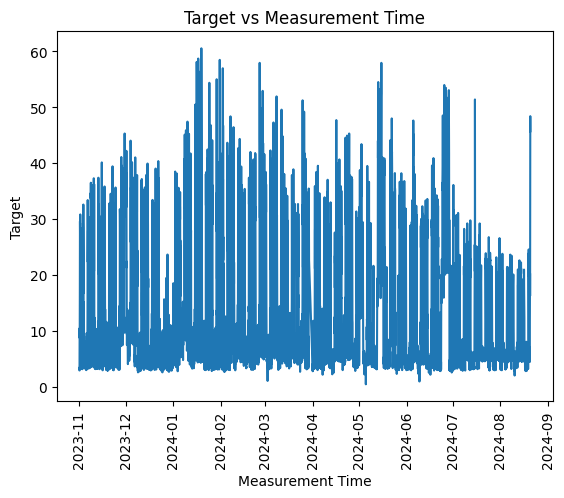

In [10]:
train['measurement_time'] = pd.to_datetime(train['measurement_time'])
# plot all values of target across measurement_time
plt.plot(train['measurement_time'], train['target'])
plt.xlabel('Measurement Time')
plt.ylabel('Target')
plt.title('Target vs Measurement Time')
plt.xticks(rotation=90)
plt.show()

In [11]:
def label_season(month):
    if month in [3, 4, 5]:
        return 'spring'
    elif month in [6, 7, 8]:
        return 'summer'
    elif month in [9, 10, 11]:
        return 'fall'
    else:
        return 'winter'
def label_time_of_day(hour):
    if hour in [6,7,8,9,10,11,12]:
        return 'morning'
    elif hour in [13,14,15,16,17]:
        return 'afternoon'
    elif hour in [18,19,20,21,22]:
        return 'evening'
    else:
        return 'night'

In [12]:
def add_lagged_features(column: pd.Series, lags=7) -> pd.Series:
    lag = []  # Initialize an empty list to store lagged values
    for i in range(len(column)):
        # Create a lag for each value in the column
        if i + lags < len(column):
            lag.append(column[i + lags])  # Append the value shifted by 'lags'
        else:
            lag.append(None)  # Append None (or np.nan) for out-of-bound indices
    
    # Convert the list of lagged values to a pandas Series and return it
    lag = pd.Series(lag, index=column.index)
    lag = lag.interpolate()
    return lag

In [13]:
# separate time_measurement into hour, day of the week and month column
train_separate = train.copy()
train_separate['hour'] = train_separate['measurement_time'].dt.hour
train_separate['day_of_week'] = train_separate['measurement_time'].dt.dayofweek
train_separate['month'] = train_separate['measurement_time'].dt.month
#train_separate['year'] = train_separate['measurement_time'].dt.year
train_separate = train_separate.drop(columns=['measurement_time'])
# Apply season labeling based on the 'Month' column
train_separate['season'] = train_separate['month'].apply(label_season).copy()
# One-hot encode the 'Season' column
train_separate = pd.get_dummies(train_separate, columns=['season'], drop_first=False).copy()
train_separate = train_separate.drop(columns=['month'])
train_separate['time_of_day'] = train_separate['hour'].apply(label_time_of_day).copy()
# One-hot encode the 'Season' column
train_separate = pd.get_dummies(train_separate, columns=['time_of_day'], drop_first=False).copy()
train_separate = train_separate.drop(columns=['hour'])
for column_label in ['mean_room_temperature', 'outside_temperature', 'wind_speed', 'clouds']:
    train_separate[column_label + '_lag'] = add_lagged_features(train_separate[column_label])
# print the variance of each column
#print(train_separate.describe())
print(train_separate.columns)
print(f"Number of missing values in train_separate: {train_separate.isnull().sum().sum()}")
# print only the columns with missing values and the number of missing values per column in train, if no missing values, no output
print(train_separate.isnull().sum()[train_separate.isnull().sum() > 0])

Index(['target', 'source_1_temperature', 'source_2_temperature',
       'source_3_temperature', 'source_4_temperature', 'mean_room_temperature',
       'sun_radiation_east', 'sun_radiation_west', 'sun_radiation_south',
       'sun_radiation_north', 'sun_radiation_perpendicular',
       'outside_temperature', 'wind_speed', 'wind_direction', 'clouds',
       'day_of_week', 'season_fall', 'season_spring', 'season_summer',
       'season_winter', 'time_of_day_afternoon', 'time_of_day_evening',
       'time_of_day_morning', 'time_of_day_night', 'mean_room_temperature_lag',
       'outside_temperature_lag', 'wind_speed_lag', 'clouds_lag'],
      dtype='object')
Number of missing values in train_separate: 0
Series([], dtype: int64)


sun_radiation_perpendicular  sun_radiation_east             0.641843
sun_radiation_west           sun_radiation_north            0.652111
                             time_of_day_afternoon          0.658339
mean_room_temperature        mean_room_temperature_lag      0.704230
source_3_temperature         source_2_temperature           0.713757
sun_radiation_east           time_of_day_morning            0.727216
outside_temperature_lag      outside_temperature            0.844622
sun_radiation_north          sun_radiation_perpendicular    0.847473
sun_radiation_south          sun_radiation_perpendicular    0.861518
season_winter                season_winter                  1.000000
dtype: float64


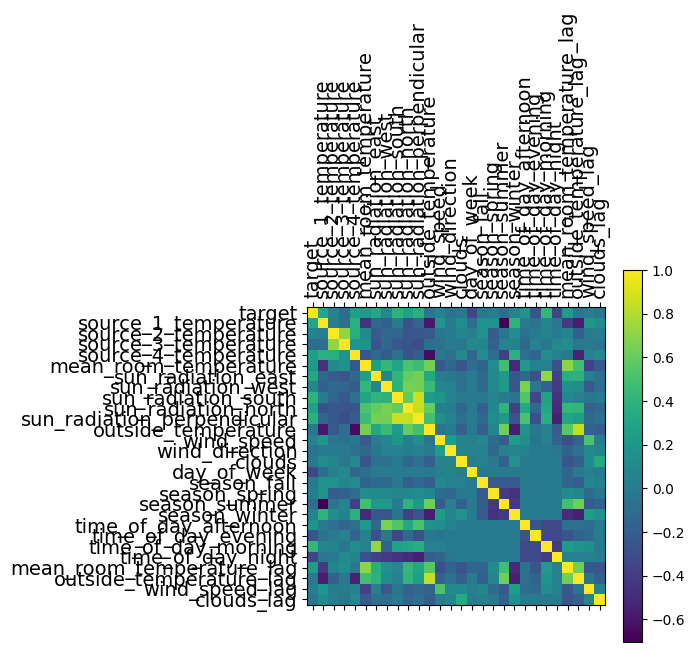

In [14]:
# Matrix of correlation between numerical columns
# only numerical columns are considered not measurement_time
train_numerical = train_separate.copy()
matrix = train_numerical.corr()
# print highest correlations var 1 var 2 corr
print(matrix.unstack().sort_values().drop_duplicates().tail(10))

plt.matshow(matrix)
# include the column names
plt.xticks(range(train_numerical.shape[1]), train_numerical.columns, fontsize=14, rotation=90)
plt.yticks(range(train_numerical.shape[1]), train_numerical.columns, fontsize=14)
plt.colorbar()
plt.show()

According to  Pearson correlation coefficient, $r > 0.75$ is considered as highly correlated. This mainly affects our results with radiation values. The following pairs of variables are highly correlated:
```
sun_radiation_north          sun_radiation_perpendicular    0.847473
sun_radiation_perpendicular  sun_radiation_south            0.861518
```
Therefore we drop `sun_radiation_perpendicular` column.

In [15]:
X = train_numerical.copy()
X = X.drop(columns=['target'])
y = train_numerical['target']
train_size = int(len(X) * 0.8)
X_train, X_val = X[:train_size], X[train_size:]
y_train, y_val = y[:train_size], y[train_size:]

In [16]:
print(f"X_train: {len(X_train)}, X_val: {len(X_val)}, Y_train: {len(y_train)}, Y_val: {len(y_val)}")

X_train: 5637, X_val: 1410, Y_train: 5637, Y_val: 1410


In [17]:
from sklearn.decomposition import PCA
from sklearn.linear_model import LinearRegression
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import mean_squared_error
from math import sqrt

# Drop 'sun_radiation_perpendicular' for Version 2
X2_train = X_train.drop(columns=['sun_radiation_perpendicular'])
X2_val = X_val.drop(columns=['sun_radiation_perpendicular'])

# Standardize the features using consistent fit and transform
scaler1 = StandardScaler()
scaler2 = StandardScaler()

# Fit scaler on training data and transform both training and validation data
X1_scaled_train = scaler1.fit_transform(X_train)
X1_scaled_val = scaler1.transform(X_val)

X2_scaled_train = scaler2.fit_transform(X2_train)
X2_scaled_val = scaler2.transform(X2_val)

# Apply PCA
pca1 = PCA()
pca2 = PCA()

# Fit PCA on training data and transform both training and validation data
X1_pca_train = pca1.fit_transform(X1_scaled_train)
X1_pca_val = pca1.transform(X1_scaled_val)

X2_pca_train = pca2.fit_transform(X2_scaled_train)
X2_pca_val = pca2.transform(X2_scaled_val)

# Train linear regression models
model1 = LinearRegression()
model1.fit(X1_pca_train, y_train)

model2 = LinearRegression()
model2.fit(X2_pca_train, y_train)

model3 = LinearRegression()
model3.fit(X_train, y_train)

# Predict on the validation set
y1_pred = model1.predict(X1_pca_val)
y2_pred = model2.predict(X2_pca_val)
y3_pred = model3.predict(X_val)

# Calculate RMSE
RMSE1 = sqrt(mean_squared_error(y_val, y1_pred)) 
RMSE2 = sqrt(mean_squared_error(y_val, y2_pred)) 
RMSE3 = sqrt(mean_squared_error(y_val, y3_pred)) 

print(f"RMSE for PCA when keeping all components: {RMSE1}")
print(f"RMSE for PCA without sun_radiation_perpendicular: {RMSE2}")
print(f"RMSE for basic: {RMSE3}")

# Check explained variance ratio
print(f"Explained variance ratio for all components (X1_pca): {pca1.explained_variance_ratio_.sum():.4f}")
print(f"Explained variance ratio without sun_radiation_perpendicular (X2_pca): {pca2.explained_variance_ratio_.sum():.4f}")

RMSE for PCA when keeping all components: 9.094705347482915
RMSE for PCA without sun_radiation_perpendicular: 9.08427111511124
RMSE for basic: 9.094483056369874
Explained variance ratio for all components (X1_pca): 1.0000
Explained variance ratio without sun_radiation_perpendicular (X2_pca): 1.0000


In [18]:
print(X.columns.values)

['source_1_temperature' 'source_2_temperature' 'source_3_temperature'
 'source_4_temperature' 'mean_room_temperature' 'sun_radiation_east'
 'sun_radiation_west' 'sun_radiation_south' 'sun_radiation_north'
 'sun_radiation_perpendicular' 'outside_temperature' 'wind_speed'
 'wind_direction' 'clouds' 'day_of_week' 'season_fall' 'season_spring'
 'season_summer' 'season_winter' 'time_of_day_afternoon'
 'time_of_day_evening' 'time_of_day_morning' 'time_of_day_night'
 'mean_room_temperature_lag' 'outside_temperature_lag' 'wind_speed_lag'
 'clouds_lag']


In [19]:
train_log = X.copy()
# apply log transformation to all numerical columns except temperature
train_log['sun_radiation_north'] = np.log1p(train_log['sun_radiation_north'])
train_log['sun_radiation_perpendicular'] = np.log1p(train_log['sun_radiation_perpendicular'])
train_log['sun_radiation_south'] = np.log1p(train_log['sun_radiation_south'])
train_log['sun_radiation_east'] = np.log1p(train_log['sun_radiation_east'])
train_log['sun_radiation_west'] = np.log1p(train_log['sun_radiation_west'])
#train_log['wind_speed'] = np.log1p(train_log['wind_speed'])
#train_log['wind_direction'] = np.log1p(train_log['wind_direction'])
#train_log['source_1_temperature'] = np.log1p(train_log['source_1_temperature'])
#train_log['source_2_temperature'] = np.log1p(train_log['source_2_temperature'])
#train_log['source_3_temperature'] = np.log1p(train_log['source_3_temperature'])
#train_log['source_4_temperature'] = np.log1p(train_log['source_4_temperature'])
#train_log['mean_room_temperature'] = np.log1p(train_log['mean_room_temperature'])
train_log['outside_temperature'] = np.log1p(train_log['outside_temperature'])
train_log['clouds'] = np.log1p(train_log['clouds'])

print(f"Number of missing values in train: {train_log.isnull().sum().sum()}")
# print only the columns with missing values and the number of missing values per column in train, if no missing values, no output
print(train_log.isnull().sum()[train_log.isnull().sum() > 0])
train_log = train_log.interpolate()
print(train_log.isnull().sum()[train_log.isnull().sum() > 0])

Number of missing values in train: 139
outside_temperature    139
dtype: int64
Series([], dtype: int64)


/Users/lauramariaquirosconesa/anaconda3/envs/energy-forecasting/lib/python3.11/site-packages/pandas/core/arraylike.py:399: RuntimeWarning: invalid value encountered in log1p
  result = getattr(ufunc, method)(*inputs, **kwargs)


In [20]:
# normalise the data
from sklearn.preprocessing import MinMaxScaler
scaler = MinMaxScaler()
train_normalised = X.copy()
train_normalised[train_normalised.columns] = scaler.fit_transform(train_normalised)

In [21]:
# normalise the data
scaler = StandardScaler()
train_normalised_std = X.copy()
train_normalised_std[train_normalised_std.columns] = scaler.fit_transform(train_normalised)

In [22]:
# Fit a linear regression model on the log and normalised data
X1 = train_log
X2 = train_normalised
X3 = train_normalised_std
X4 = train_numerical.drop(columns=['target'])

X = [X1, X2, X3, X4]
labels = [" logged", " normalised minmax", " normalised standard", ""]

for i in range(len(X)):
    data = X[i]
    datay = y
    label : str = labels[i]
    train_size = int(len(data) * 0.8)
    X_train, X_test = data[:train_size], data[train_size:]
    y_train, y_test = datay[:train_size], datay[train_size:]
    model = LinearRegression()
    model.fit(X_train, y_train)
    # Predict the target variable on the test set
    y_pred = model.predict(X_test)
    # Calculate R-squared to see how well the target is predicted by the PCA components
    rmse = sqrt(mean_squared_error(y_test, y_pred))
    # Output the amount of variance explained by the PCA components in the target
    print("RMSE with" + label + f" numerical components: {rmse}")

RMSE with logged numerical components: 8.686533910247368
RMSE with normalised minmax numerical components: 9.094483056369935
RMSE with normalised standard numerical components: 9.094483056369958
RMSE with numerical components: 9.094483056369874


In [23]:
# Do minmax and log
N = int(len(train_log) * 0.8)
X_train, X_test = train_log[:N], train_log[N:]
y_train, y_test = y[:N], y[N:]

scaler1 = MinMaxScaler()
scaler2 = MinMaxScaler()
X_train[X_train.columns] = scaler1.fit_transform(X_train)
X_test[X_test.columns] = scaler2.fit_transform(X_test)

model = LinearRegression()
model.fit(X_train, y_train)
y_pred = model.predict(X_test)

#calculate RMSE
RMSE1 = sqrt(mean_squared_error(y_test, y_pred)) 
print(f"RMSE for minmax and log: {RMSE1}")

RMSE for PCA with minmax and log: 8.680189818651208


/var/folders/jx/nw81mq5d1cl9wrj1h46m_m9h0000gn/T/ipykernel_7371/1654268010.py:8: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  X_train[X_train.columns] = scaler1.fit_transform(X_train)
/var/folders/jx/nw81mq5d1cl9wrj1h46m_m9h0000gn/T/ipykernel_7371/1654268010.py:9: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  X_test[X_test.columns] = scaler2.fit_transform(X_test)


In [25]:
# Do minmax and log with PCA
N = int(len(train_log) * 0.8)
X_train, X_test = train_log[:N], train_log[N:]
y_train, y_test = y[:N], y[N:]

scaler1 = MinMaxScaler()
scaler2 = MinMaxScaler()
X_train[X_train.columns] = scaler1.fit_transform(X_train)
X_test[X_test.columns] = scaler2.fit_transform(X_test)
pca = PCA()
X_pca_train = pca.fit_transform(X_train)
X_pca_test = pca.transform(X_test)

model = LinearRegression()
model.fit(X_pca_train, y_train)
y_pred = model.predict(X_pca_test)

#calculate RMSE
RMSE1 = sqrt(mean_squared_error(y_test, y_pred)) 
print(f"RMSE for PCA with minmax and log: {RMSE1}")

RMSE for PCA with minmax and log: 7162542679646.218


/var/folders/jx/nw81mq5d1cl9wrj1h46m_m9h0000gn/T/ipykernel_7371/1737542943.py:8: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  X_train[X_train.columns] = scaler1.fit_transform(X_train)
/var/folders/jx/nw81mq5d1cl9wrj1h46m_m9h0000gn/T/ipykernel_7371/1737542943.py:9: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  X_test[X_test.columns] = scaler2.fit_transform(X_test)
